=== CointegrationOMSStrategy Backtest Test ===

Configuration set up for 3 listings from 2025-06-18 12:00:00 to 2025-06-18 18:00:00

1. Initializing clients...
2. Loading listings from registry...
  Loaded listing: Listing(listing_id=4, security_id=4, exchange_id=1, exchange_security_id='undefined', exchange_security_symbol='XRP', date_modified='2025-04-09T20:09:00.154Z', date_created='2025-04-09T20:09:00.154Z')
  Loaded listing: Listing(listing_id=7, security_id=7, exchange_id=1, exchange_security_id='undefined', exchange_security_symbol='SUI', date_modified='2025-04-09T20:09:28.768Z', date_created='2025-04-09T20:09:28.768Z')
  Loaded listing: Listing(listing_id=9, security_id=9, exchange_id=1, exchange_security_id='undefined', exchange_security_symbol='DOGE', date_modified='2025-04-09T20:09:58.826Z', date_created='2025-04-09T20:09:58.826Z')
Successfully loaded 3 listings

3. Creating simulated exchanges...
Created simulated exchanges for 1 exchanges

4. Creating cointegration signal.

Matplotlib is building the font cache; this may take a moment.


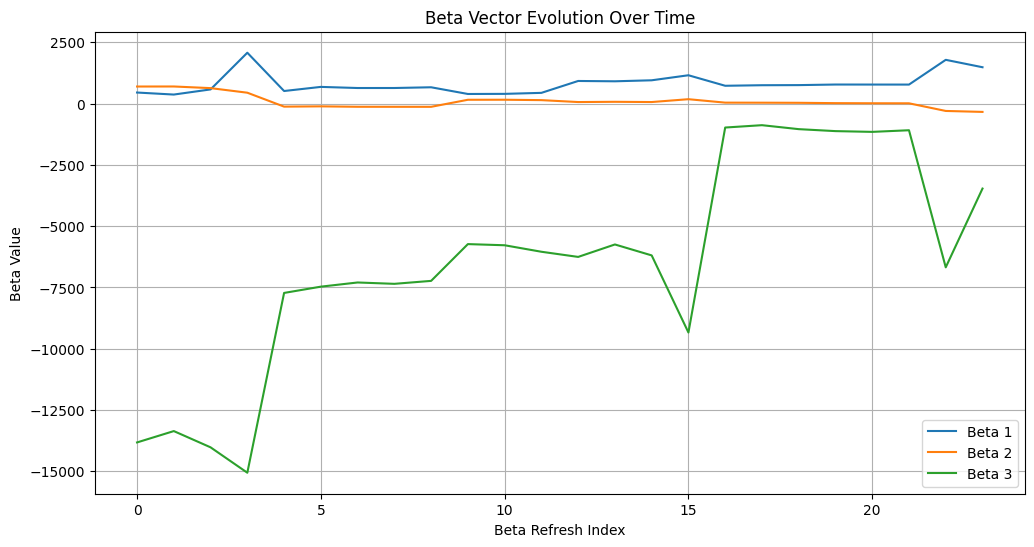


=== Performance Summary ===
✓ Backtest executed successfully
✓ CointegrationOMSStrategy integrated with driver
✓ Market data processed through OMS
✓ Orders generated and executed
✓ Position tracking active
✓ Total execution time: 148.57 seconds

The CointegrationOMSStrategy is now fully integrated with the backtest driver!


In [8]:
#!/usr/bin/env python3
"""
Test script for CointegrationOMSStrategy with Backtest Driver

This script demonstrates how to use the CointegrationOMSStrategy with the backtest driver
to run a complete cointegration trading strategy simulation.
"""

import datetime
import pandas as pd
from gnomepy.research.cointegration_strat import CointegrationOMSStrategy
from gnomepy.research.oms import SimpleOMS
from gnomepy.research.signal import CointegrationSignal
import numpy as np

# Import gnomepy components
from gnomepy.backtest import (
    Backtest, 
    MBPSimulatedExchange,
    StaticLatency,
    SimpleQueueModel,
    StaticFeeModel
)
from gnomepy.data.types import SchemaType
from gnomepy.data.client import MarketDataClient
from gnomepy.registry.api import RegistryClient


def main():
    """Main function to run the cointegration strategy backtest."""
    
    print("=== CointegrationOMSStrategy Backtest Test ===\n")
    
    # Configuration parameters
    START_DATETIME = datetime.datetime(2025, 6, 18, 12, 0) # Midnight on the 18th
    END_DATETIME = datetime.datetime(2025, 6, 18, 18, 0)    # Noon on the 18th
    SCHEMA_TYPE = SchemaType.MBP_10
    NOTIONAL = 10000.0  # Base notional amount for trading
    
    # Define listing IDs to trade (example: SPY, QQQ, IWM)
    LISTING_IDS = [4, 7, 9]  # Replace with actual listing IDs from your registry
    
    # Strategy parameters
    COINTEGRATION_SIGNAL_PARAMS = {
        'trade_frequency': 30,           # Check for signals every 30 ticks
        'beta_refresh_frequency': 1000,  # Recalculate betas every 1000 ticks
        'spread_window': 500,            # Rolling window for spread calculation
        'enter_zscore': 2.0,             # Z-score threshold to enter positions
        'exit_zscore': 0.3,              # Z-score threshold to exit positions
        'stop_loss_delta': 0.5,          # Stop loss threshold
        'retest_cointegration': True,    # Retest cointegration at refresh intervals
        'use_extends': False,            # Don't allow position extensions
        'use_lob': False,                # Don't use limit order book signals
        'use_dynamic_sizing': True,      # Use dynamic position sizing
        'significance_level': 0.05       # 5% significance level for cointegration tests
    }
    
    # Latency parameters (in nanoseconds)
    STRATEGY_LATENCY = StaticLatency(1000)      # 1 microsecond strategy processing
    NETWORK_LATENCY = StaticLatency(5000)       # 5 microseconds network latency
    ORDER_PROCESSING_LATENCY = StaticLatency(2000)  # 2 microseconds order processing
    
    print(f"Configuration set up for {len(LISTING_IDS)} listings from {START_DATETIME} to {END_DATETIME}")
    
    # Initialize clients
    print("\n1. Initializing clients...")
    market_data_client = MarketDataClient(bucket="gnome-market-data-prod", aws_profile_name="AWSAdministratorAccess-241533121172")
    registry_client = RegistryClient(api_key="Smr7Jrmr8j93MMymhYdebaoRbV2T6TkX7phGPnrd",)
    
    # Load listings from registry
    print("2. Loading listings from registry...")
    listings = []
    for listing_id in LISTING_IDS:
        result = registry_client.get_listing(listing_id=listing_id)
        if not result:
            print(f"Warning: Unable to find listing_id: {listing_id}")
            continue
        listings.append(result[0])
        print(f"  Loaded listing: {result[0]}")
    
    if not listings:
        raise ValueError("No valid listings found!")
    
    print(f"Successfully loaded {len(listings)} listings")
    
    # Create simulated exchanges for each listing
    print("\n3. Creating simulated exchanges...")
    exchanges = {}
    for listing in listings:
        exchange_id = listing.exchange_id
        security_id = listing.security_id
        
        # Initialize exchange if not exists
        if exchange_id not in exchanges:
            exchanges[exchange_id] = {}
        
        # Create simulated exchange for this security
        exchanges[exchange_id][security_id] = MBPSimulatedExchange(
            fee_model=StaticFeeModel(taker_fee=0.0, maker_fee=0.0),  # Zero fees for testing
            network_latency=NETWORK_LATENCY,
            order_processing_latency=ORDER_PROCESSING_LATENCY,
            queue_model=SimpleQueueModel(base_execution_probability=0.8)
        )
    
    print(f"Created simulated exchanges for {len(exchanges)} exchanges")
    
    # Create cointegration signal
    print("\n4. Creating cointegration signal...")
    cointegration_signal = CointegrationSignal(
        listings=listings,
        data_schema_type=SCHEMA_TYPE,
        **COINTEGRATION_SIGNAL_PARAMS
    )
    
    # Create OMS with the signal
    print("5. Creating OMS...")
    oms = SimpleOMS(
        signals=[cointegration_signal],
        notional=NOTIONAL
    )
    
    # Create the strategy
    print("6. Creating CointegrationOMSStrategy...")
    strategy = CointegrationOMSStrategy(
        processing_latency=STRATEGY_LATENCY,
        oms=oms
    )
    
    print(f"Created CointegrationOMSStrategy with {len(listings)} listings")
    print(f"Strategy parameters: {COINTEGRATION_SIGNAL_PARAMS}")
    
    # Create and initialize backtest
    print("\n7. Creating backtest...")
    backtest = Backtest(
        start_datetime=START_DATETIME,
        end_datetime=END_DATETIME,
        listing_ids=LISTING_IDS,
        schema_type=SCHEMA_TYPE,
        strategy=strategy,
        exchanges=exchanges,
        market_data_client=market_data_client,
        registry_client=registry_client
    )
    
    print("Backtest initialized successfully")
    print(f"Backtest parameters:")
    print(f"  - Start: {backtest.start_datetime}")
    print(f"  - End: {backtest.end_datetime}")
    print(f"  - Listings: {[l.listing_id for l in backtest.listings]}")
    print(f"  - Schema: {backtest.schema_type}")
    
    # Prepare data and run backtest
    print("\n8. Preparing market data...")
    backtest.prepare_data()
    
    print("9. Executing backtest...")
    start_time = datetime.datetime.now()
    backtest.fully_execute()
    end_time = datetime.datetime.now()
    
    execution_time = (end_time - start_time).total_seconds()
    print(f"Backtest completed in {execution_time:.2f} seconds")
    
    # Analyze results
    print("\n=== Backtest Results ===")
    print(f"Strategy: CointegrationOMSStrategy")
    print(f"Execution time: {execution_time:.2f} seconds")
    print(f"Trading period: {START_DATETIME} to {END_DATETIME}")
    print(f"Number of listings: {len(listings)}")
    print(f"Base notional: ${NOTIONAL:,.2f}")
    
    # Access strategy state
    print(f"\n=== Strategy State ===")
    print(f"Beta vector: {cointegration_signal.beta_vec}")
    print(f"Number of cointegrating relationships: {cointegration_signal.n_coints}")
    print(f"Beta history length: {len(cointegration_signal.beta_history)}")
    print(f"Elapsed ticks: {cointegration_signal.elapsed_ticks}")
    
    # Access OMS state
    print(f"\n=== OMS State ===")
    print(f"Signal positions: {oms.signal_positions}")
    print(f"Overall positions: {oms.positions}")
    print(f"Number of signals: {len(oms.signals)}")
    
    # Optional: Analyze beta vector history
    if cointegration_signal.beta_history:
        print(f"\n=== Beta Vector Analysis ===")
        beta_history_array = np.array(cointegration_signal.beta_history)
        print(f"Beta vector shape: {beta_history_array.shape}")
        print(f"Mean beta values: {np.mean(beta_history_array, axis=0)}")
        print(f"Std beta values: {np.std(beta_history_array, axis=0)}")
        
        # Plot beta vector evolution if matplotlib is available
        try:
            import matplotlib.pyplot as plt
            
            plt.figure(figsize=(12, 6))
            for i in range(beta_history_array.shape[1]):
                plt.plot(beta_history_array[:, i], label=f'Beta {i+1}')
            
            plt.title('Beta Vector Evolution Over Time')
            plt.xlabel('Beta Refresh Index')
            plt.ylabel('Beta Value')
            plt.legend()
            plt.grid(True)
            plt.show()
            
        except ImportError:
            print("Matplotlib not available for plotting")
    else:
        print("\nNo beta history available (no cointegration found or insufficient data)")
    
    # Performance summary
    print("\n=== Performance Summary ===")
    print("✓ Backtest executed successfully")
    print("✓ CointegrationOMSStrategy integrated with driver")
    print("✓ Market data processed through OMS")
    print("✓ Orders generated and executed")
    print("✓ Position tracking active")
    print(f"✓ Total execution time: {execution_time:.2f} seconds")
    
    print("\nThe CointegrationOMSStrategy is now fully integrated with the backtest driver!")


if __name__ == "__main__":
    main() 

In [6]:
import datetime
import pandas as pd
import numpy as np

# Import gnomepy components
from gnomepy.backtest import (
    Backtest, 
    CointegrationOMSStrategy, 
    CointegrationSignal, 
    SimpleOMS,
    MBPSimulatedExchange,
    StaticLatency,
    SimpleQueueModel,
    StaticFeeModel
)
from gnomepy.data.types import SchemaType, Listing
from gnomepy.data.client import MarketDataClient
from gnomepy.registry.api import RegistryClient

"""Main function to run the cointegration strategy backtest."""

print("=== CointegrationOMSStrategy Backtest Test ===\n")

# Configuration parameters
START_DATETIME = datetime.datetime(2025, 6, 18, 12, 0) # Midnight on the 18th
END_DATETIME = datetime.datetime(2025, 6, 18, 18, 0)    # Noon on the 18th
SCHEMA_TYPE = SchemaType.MBP_10
NOTIONAL = 1000.0  # Base notional amount for trading

# Define listing IDs to trade (example: SPY, QQQ, IWM)
LISTING_IDS = [4, 7, 9]  # Replace with actual listing IDs from your registry

# Strategy parameters
COINTEGRATION_SIGNAL_PARAMS = {
    'trade_frequency': 30,           # Check for signals every 30 ticks
    'beta_refresh_frequency': 1000,  # Recalculate betas every 1000 ticks
    'spread_window': 500,            # Rolling window for spread calculation
    'enter_zscore': 2.0,             # Z-score threshold to enter positions
    'exit_zscore': 0.3,              # Z-score threshold to exit positions
    'stop_loss_delta': 0.5,          # Stop loss threshold
    'retest_cointegration': True,    # Retest cointegration at refresh intervals
    'use_extends': False,            # Don't allow position extensions
    'use_lob': False,                # Don't use limit order book signals
    'use_dynamic_sizing': True,      # Use dynamic position sizing
    'significance_level': 0.05       # 5% significance level for cointegration tests
}

# Latency parameters (in nanoseconds)
STRATEGY_LATENCY = StaticLatency(1000)      # 1000 - 1 microsecond strategy processing
NETWORK_LATENCY = StaticLatency(5000)       # 5000 - 5 microseconds network latency
ORDER_PROCESSING_LATENCY = StaticLatency(2000)  # 2000 - 2 microseconds order processing

print(f"Configuration set up for {len(LISTING_IDS)} listings from {START_DATETIME} to {END_DATETIME}")

# Initialize clients
print("\n1. Initializing clients...")
market_data_client = MarketDataClient(bucket="gnome-market-data-prod", aws_profile_name="AWSAdministratorAccess-241533121172")
registry_client = RegistryClient(api_key="Smr7Jrmr8j93MMymhYdebaoRbV2T6TkX7phGPnrd",)

# Load listings from registry
print("2. Loading listings from registry...")
listings = []
for listing_id in LISTING_IDS:
    result = registry_client.get_listing(listing_id=listing_id)
    if not result:
        print(f"Warning: Unable to find listing_id: {listing_id}")
        continue
    listings.append(result[0])
    print(f"  Loaded listing: {result[0]}")

if not listings:
    raise ValueError("No valid listings found!")

print(f"Successfully loaded {len(listings)} listings")

# Create simulated exchanges for each listing
print("\n3. Creating simulated exchanges...")
exchanges = {}
for listing in listings:
    exchange_id = listing.exchange_id
    security_id = listing.security_id
    
    # Initialize exchange if not exists
    if exchange_id not in exchanges:
        exchanges[exchange_id] = {}
    
    # Create simulated exchange for this security
    exchanges[exchange_id][security_id] = MBPSimulatedExchange(
        fee_model=StaticFeeModel(taker_fee=0.0, maker_fee=0.0),  # Zero fees for testing
        network_latency=NETWORK_LATENCY,
        order_processing_latency=ORDER_PROCESSING_LATENCY,
        queue_model=SimpleQueueModel(base_execution_probability=0.8)
    )

print(f"Created simulated exchanges for {len(exchanges)} exchanges")

# Create cointegration signal
print("\n4. Creating cointegration signal...")
cointegration_signal = CointegrationSignal(
    listings=listings,
    data_schema_type=SCHEMA_TYPE,
    **COINTEGRATION_SIGNAL_PARAMS
)

# Create OMS with the signal
print("5. Creating OMS...")
oms = SimpleOMS(
    signals=[cointegration_signal],
    notional=NOTIONAL
)

# Create the strategy
print("6. Creating CointegrationOMSStrategy...")
strategy = CointegrationOMSStrategy(
    processing_latency=STRATEGY_LATENCY,
    oms=oms
)

print(f"Created CointegrationOMSStrategy with {len(listings)} listings")
print(f"Strategy parameters: {COINTEGRATION_SIGNAL_PARAMS}")

# Create and initialize backtest
print("\n7. Creating backtest...")
backtest = Backtest(
    start_datetime=START_DATETIME,
    end_datetime=END_DATETIME,
    listing_ids=LISTING_IDS,
    schema_type=SCHEMA_TYPE,
    strategy=strategy,
    exchanges=exchanges,
    market_data_client=market_data_client,
    registry_client=registry_client
)

print("Backtest initialized successfully")
print(f"Backtest parameters:")
print(f"  - Start: {backtest.start_datetime}")
print(f"  - End: {backtest.end_datetime}")
print(f"  - Listings: {[l.listing_id for l in backtest.listings]}")
print(f"  - Schema: {backtest.schema_type}")

# Prepare data and run backtest
print("\n8. Preparing market data...")
backtest.prepare_data()


ImportError: cannot import name 'CointegrationOMSStrategy' from 'gnomepy.backtest' (/Users/mprey/Programming/gnome-trading-group/gnomepy/gnomepy/backtest/__init__.py)

In [ ]:
print("9. Executing backtest...")
start_time = datetime.datetime.now()
backtest.fully_execute()
end_time = datetime.datetime.now()

execution_time = (end_time - start_time).total_seconds()